**Table of contents**<a id='toc0_'></a>    
- [Data Collection](#toc1_1_)    
      - [Small task: Process dataframe structure](#toc1_1_1_1_)    
  - [Feature Engineering](#toc1_2_)    
    - [Technical Analysis](#toc1_2_1_)    
      - [RSI Index](#toc1_2_1_1_)    
      - [MACD Index](#toc1_2_1_2_)    
      - [MFI Index](#toc1_2_1_3_)    
      - [Stochastic Oscillator](#toc1_2_1_4_)    
    - [Plot the NFLX Price values over time](#toc1_2_2_)    
    - [Other related features](#toc1_2_3_)    
      - [If the dividends/ split data is not available in the set, we can approximate Adjusted Closing Price to be close to Close Price](#toc1_2_3_1_)    
      - [Log Return calculated using Adjusted Close Price](#toc1_2_3_2_)    
      - [Realized Volatility](#toc1_2_3_3_)    
      - [Some Time features like year, Month, weekday](#toc1_2_3_4_)    
  - [Clean and Preprocessing](#toc1_3_)    
    - [Check for stationarity of Close price](#toc1_3_1_)    
      - [Pre-requisites:](#toc1_3_1_1_)    
      - [Augmented Dickey-Fuller Test (ADF test):](#toc1_3_1_2_)    
      - [Kwiatkowski-Phillips-Schmidt-Shin Test (KPSS):](#toc1_3_1_3_)    
      - [Ljung-Box Test](#toc1_3_1_4_)    
      - [ARCH test](#toc1_3_1_5_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

In [ ]:
import pandas as pd
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt

#Fetching stock data with the given name
import yfinance as yf

#For fetching data from Wikipedia
from bs4 import BeautifulSoup
import requests
from io import StringIO

#for technical analysis
import ta
import mplfinance as mpf
import plotly.graph_objects as go

#Time series decomposition and forecasting prep
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller, acf, pacf, kpss
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.stats.diagnostic import acorr_ljungbox, het_arch

## <a id='toc1_1_'></a>[Data Collection](#toc0_)

In [20]:
def get_sp100_constituents():
    url = "https://en.wikipedia.org/wiki/S%26P_100"
    headers = {"User-Agent": "Mozilla/5.0"}
    
    html = requests.get(url, headers=headers).text
    
    # Wrap in StringIO to silence the warning
    tables = pd.read_html(StringIO(html))
    
    sp100 = [t for t in tables if t.shape[0] > 50 and t.shape[1] >= 3][0]
    sp100.columns = ["Symbol", "Name", "Sector"]
    
    return sp100


sp100 = get_sp100_constituents()
sp100 = sp100[sp100['Symbol'] != 'PLTR']
print(sp100.shape)

(100, 3)


In [22]:
# get tickers from your sp100 dataframe
tickers = sp100["Symbol"].tolist()

# fetch 10 years of daily data
data = yf.download(
    tickers,
    start="2013-01-01",
    end="2023-12-31",
    interval="1d",
    group_by="ticker",
    auto_adjust=True,   # adjust for splits/dividends
    threads=True
)

[*********************102%************************]  102 of 100 completedompleted

1 Failed download:
[*********************103%************************]  103 of 100 completed['BRK.B']: YFTzMissingError('possibly delisted; no timezone found')
[*********************************150%***********************************]  150 of 100 completed

In [8]:
df = pd.read_csv('D:/Study/Education/Projects/OmniTS/data/raw_price_sp100.csv')

C:\Users\admin\AppData\Local\Temp\ipykernel_17832\1898089444.py:1: DtypeWarning: Columns (1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,25

In [35]:
data.head()

Ticker           NFLX                                                   LIN  \
Price            Open       High        Low      Close    Volume       Open   
Date                                                                          
2013-01-02  13.601429  13.687143  12.955714  13.144286  19431300  87.786133   
2013-01-03  13.138571  13.988571  13.075714  13.798571  27912500  89.162983   
2013-01-04  13.791429  13.958571  13.648571  13.711429  17761100  89.352847   
2013-01-07  13.770000  14.535714  13.731429  14.171429  45550400  89.170853   
2013-01-08  14.287143  14.427143  13.828571  13.880000  24714900  89.511132   

Ticker                                                ...        CVX  \
Price            High        Low      Close   Volume  ...       Open   
Date                                                  ...              
2013-01-02  89.083855  87.754481  89.083855  1088100  ...  65.003707   
2013-01-03  89.780191  88.735683  89.083855   971200  ...  64.927099   
2013-01-04  90.001707  89.194590  89.685188   771700  ...  64.838661   
2013-01-07  89.685189  88.917640  89.487366   874500  ...  64.856344   
2013-01-08  90.144163  89.075918  90.112511   860900  ...  64.538023   

Ticker                                               AVGO                 \
Price            High        Low      Close   Volume Open High Low Close   
Date                                                                       
2013-01-02  65.092132  64.101779  65.074448  6144100  NaN  NaN NaN   NaN   
2013-01-03  65.386905  64.555718  64.797409  6817000  NaN  NaN NaN   NaN   
2013-01-04  65.210046  64.785608  65.139305  4414500  NaN  NaN NaN   NaN   
2013-01-07  64.897608  64.367065  64.697182  4861000  NaN  NaN NaN   NaN   
2013-01-08  64.661816  64.314011  64.408333  6325400  NaN  NaN NaN   NaN   

Ticker             
Price      Volume  
Date               
2013-01-02    NaN  
2013-01-03    NaN  
2013-01-04    NaN  
2013-01-07    NaN  
2013-01-08    NaN  

[5 rows x 501 columns]

The data is organized in multiIndex hierarchical column name, so we need to find a way to break down/ flatten into single index and also bring the Date from index to actual column

#### <a id='toc1_1_1_1_'></a>[Small task: Process dataframe structure](#toc0_)

Approach 1

In [43]:
df = pd.DataFrame(data.to_records())

df.head()

,Date,"('NFLX', 'Open')","('NFLX', 'High')","('NFLX', 'Low')","('NFLX', 'Close')","('NFLX', 'Volume')","('LIN', 'Open')","('LIN', 'High')","('LIN', 'Low')","('LIN', 'Close')",...,"('CVX', 'Open')","('CVX', 'High')","('CVX', 'Low')","('CVX', 'Close')","('CVX', 'Volume')","('AVGO', 'Open')","('AVGO', 'High')","('AVGO', 'Low')","('AVGO', 'Close')","('AVGO', 'Volume')"
0,2013-01-02,13.601429,13.687143,12.955714,13.144286,19431300,87.786133,89.083855,87.754481,89.083855,...,65.003707,65.092132,64.101779,65.074448,6144100,NaN,NaN,NaN,NaN,NaN
1,2013-01-03,13.138571,13.988571,13.075714,13.798571,27912500,89.162983,89.780191,88.735683,89.083855,...,64.927099,65.386905,64.555718,64.797409,6817000,NaN,NaN,NaN,NaN,NaN
2,2013-01-04,13.791429,13.958571,13.648571,13.711429,17761100,89.352847,90.001707,89.194590,89.685188,...,64.838661,65.210046,64.785608,65.139305,4414500,NaN,NaN,NaN,NaN,NaN
3,2013-01-07,13.770000,14.535714,13.731429,14.171429,45550400,89.170853,89.685189,88.917640,89.487366,...,64.856344,64.897608,64.367065,64.697182,4861000,NaN,NaN,NaN,NaN,NaN
4,2013-01-08,14.287143,14.427143,13.828571,13.880000,24714900,89.511132,90.144163,89.075918,90.112511,...,64.538023,64.661816,64.314011,64.408333,6325400,NaN,NaN,NaN,NaN,NaN


Approach 2

In [25]:
data_flat = data.copy()
data_flat.columns = data.columns.to_flat_index()

In [55]:
df.head()

,Date,NFLX_ Open,NFLX_ High,NFLX_ Low,NFLX_ Close,NFLX_ Volume,LIN_ Open,LIN_ High,LIN_ Low,LIN_ Close,...,CVX_ Open,CVX_ High,CVX_ Low,CVX_ Close,CVX_ Volume,AVGO_ Open,AVGO_ High,AVGO_ Low,AVGO_ Close,AVGO_ Volume
0,2013-01-02,13.601429,13.687143,12.955714,13.144286,19431300,87.786133,89.083855,87.754481,89.083855,...,65.003707,65.092132,64.101779,65.074448,6144100,NaN,NaN,NaN,NaN,NaN
1,2013-01-03,13.138571,13.988571,13.075714,13.798571,27912500,89.162983,89.780191,88.735683,89.083855,...,64.927099,65.386905,64.555718,64.797409,6817000,NaN,NaN,NaN,NaN,NaN
2,2013-01-04,13.791429,13.958571,13.648571,13.711429,17761100,89.352847,90.001707,89.194590,89.685188,...,64.838661,65.210046,64.785608,65.139305,4414500,NaN,NaN,NaN,NaN,NaN
3,2013-01-07,13.770000,14.535714,13.731429,14.171429,45550400,89.170853,89.685189,88.917640,89.487366,...,64.856344,64.897608,64.367065,64.697182,4861000,NaN,NaN,NaN,NaN,NaN
4,2013-01-08,14.287143,14.427143,13.828571,13.880000,24714900,89.511132,90.144163,89.075918,90.112511,...,64.538023,64.661816,64.314011,64.408333,6325400,NaN,NaN,NaN,NaN,NaN


In [ ]:
# df.to_csv('D:/Study/Education/Projects/OmniTS/data/raw_price_sp100.csv')

In [62]:
df_NFLX = df[['Date', 'NFLX_Open', 'NFLX_High', 'NFLX_Low', 'NFLX_Close', 'NFLX_Volume']]

In [66]:
df_NFLX

,Date,NFLX_Open,NFLX_High,NFLX_Low,NFLX_Close,NFLX_Volume
0,2013-01-02,13.601429,13.687143,12.955714,13.144286,19431300
1,2013-01-03,13.138571,13.988571,13.075714,13.798571,27912500
2,2013-01-04,13.791429,13.958571,13.648571,13.711429,17761100
3,2013-01-07,13.770000,14.535714,13.731429,14.171429,45550400
4,2013-01-08,14.287143,14.427143,13.828571,13.880000,24714900
...,...,...,...,...,...,...
2763,2023-12-22,494.000000,496.019989,485.450012,486.760010,2702700
2764,2023-12-26,489.390015,491.480011,486.380005,491.190002,2034500
2765,2023-12-27,491.239990,494.019989,489.250000,491.790009,2561300
2766,2023-12-28,492.000000,492.890015,489.070007,490.510010,1710500


# <a id='toc1_2_'></a>[Feature Engineering](#toc0_)

### <a id='toc1_2_1_'></a>[Technical Analysis](#toc0_)

In [65]:
df_NFLX['Date'] = pd.to_datetime(df_NFLX['Date'])

C:\Users\admin\AppData\Local\Temp\ipykernel_3436\683461793.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_NFLX['Date'] = pd.to_datetime(df_NFLX['Date'])


#### <a id='toc1_2_1_1_'></a>[RSI Index](#toc0_)

In [ ]:
def calculate_rsi_wilder(series: pd.Series, period: int = 14) -> pd.Series:
    delta = series.diff()
    gain = delta.clip(lower=0)
    loss = -delta.clip(upper=0)

    # Wilder's smoothing is basically EMA with alpha = 1/period
    avg_gain = gain.ewm(alpha=1/period, adjust=False).mean()
    avg_loss = loss.ewm(alpha=1/period, adjust=False).mean()

    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

df_NFLX['RSI_14'] = calculate_rsi_wilder(df_NFLX['close'], period=14)

In [ ]:
df_NFLX["RSI"] = ta.momentum.RSIIndicator(df_NFLX["NFLX_Close"], window=14).rsi()

#### <a id='toc1_2_1_2_'></a>[MACD Index](#toc0_)

In [ ]:
def EMA(series: pd.Series, period: int = 12) -> pd.Series:
    ema = series.ewm(span=period, adjust=False).mean()
    ema.iloc[:period-1] = np.nan  # mask first values
    return ema

df_NFLX['EMA_12'] = EMA(df_NFLX['NFLX_Close'], period=12)
df_NFLX['EMA_26'] = EMA(df_NFLX['NFLX_Close'], period=26)
df_NFLX['MACD'] = df_NFLX['EMA_12'] - df_NFLX['EMA_26']
df_NFLX['Signal_Line'] = EMA(df_NFLX['MACD'], period=9)

#### <a id='toc1_2_1_3_'></a>[MFI Index](#toc0_)

In [ ]:
df_NFLX['TP'] = (df_NFLX['NFLX_High'] + df_NFLX['NFLX_Low'] + df_NFLX['NFLX_Close']) / 3

df_NFLX['MF'] = df_NFLX['TP'] * df_NFLX['NFLX_Volume']

df_NFLX['PMF'] = np.where(df_NFLX['TP'] > df_NFLX['TP'].shift(1), df_NFLX['MF'], 0)
df_NFLX['NMF'] = np.where(df_NFLX['TP'] < df_NFLX['TP'].shift(1), df_NFLX['MF'], 0)

df_NFLX['PMF_sum'] = df_NFLX['PMF'].rolling(window=14).sum()
df_NFLX['NMF_sum'] = df_NFLX['NMF'].rolling(window=14).sum()  

df_NFLX['MR'] = df_NFLX['PMF_sum'] / df_NFLX['NMF_sum']
df_NFLX['MFI'] = 100 - (100 / (1 + df_NFLX['MR']))

In [74]:
df_NFLX.columns = df_NFLX.columns.str.replace('NFLX_', '')

#### <a id='toc1_2_1_4_'></a>[Stochastic Oscillator](#toc0_)

In [85]:
def stochastic_oscillator(df, k_period=14, d_period=3):
    # Highest high & lowest low over the lookback window
    low_min = df['Low'].rolling(window=k_period).min()
    high_max = df['High'].rolling(window=k_period).max()
    
    # %K line
    k_percent = 100 * (df['Close'] - low_min) / (high_max - low_min)
    
    # %D line (moving average of %K)
    d_percent = k_percent.rolling(window=d_period).mean()
    
    return k_percent, d_percent

df_NFLX['%K'], df_NFLX['%D'] = stochastic_oscillator(df_NFLX, k_period=14, d_period=3)

C:\Users\admin\AppData\Local\Temp\ipykernel_3436\3413405713.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_NFLX['%K'], df_NFLX['%D'] = stochastic_oscillator(df_NFLX, k_period=14, d_period=3)
C:\Users\admin\AppData\Local\Temp\ipykernel_3436\3413405713.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_NFLX['%K'], df_NFLX['%D'] = stochastic_oscillator(df_NFLX, k_period=14, d_period=3)


In [76]:
df_NFLX.head()

,Date,Open,High,Low,Close,Volume,RSI,EMA_12,EMA_26,MACD,Signal_Line,TP,MF,PMF,NMF,PMF_sum,NMF_sum,MR,MFI
0,2013-01-02,13.601429,13.687143,12.955714,13.144286,19431300,NaN,NaN,NaN,NaN,NaN,13.262381,2.577053e+08,0.000000e+00,0.000000e+00,NaN,NaN,NaN,NaN
1,2013-01-03,13.138571,13.988571,13.075714,13.798571,27912500,NaN,NaN,NaN,NaN,NaN,13.620952,3.801948e+08,3.801948e+08,0.000000e+00,NaN,NaN,NaN,NaN
2,2013-01-04,13.791429,13.958571,13.648571,13.711429,17761100,NaN,NaN,NaN,NaN,NaN,13.772857,2.446211e+08,2.446211e+08,0.000000e+00,NaN,NaN,NaN,NaN
3,2013-01-07,13.770000,14.535714,13.731429,14.171429,45550400,NaN,NaN,NaN,NaN,NaN,14.146191,6.443646e+08,6.443646e+08,0.000000e+00,NaN,NaN,NaN,NaN
4,2013-01-08,14.287143,14.427143,13.828571,13.880000,24714900,NaN,NaN,NaN,NaN,NaN,14.045238,3.471267e+08,0.000000e+00,3.471267e+08,NaN,NaN,NaN,NaN


### <a id='toc1_2_2_'></a>[Plot the NFLX Price values over time](#toc0_)

d:\Study\Setup\anaconda\config\Lib\site-packages\mplfinance\_arg_validators.py:84: UserWarning: 


            POSSIBLE TO SEE DETAILS (Candles, Ohlc-Bars, Etc.)
   For more information see:
   - https://github.com/matplotlib/mplfinance/wiki/Plotting-Too-Much-Data
   
   TO SILENCE THIS WARNING, set `type='line'` in `mpf.plot()`
   OR set kwarg `warn_too_much_data=N` where N is an integer 
   LARGER than the number of data points you want to plot.

  warnings.warn('\n\n ================================================================= '+


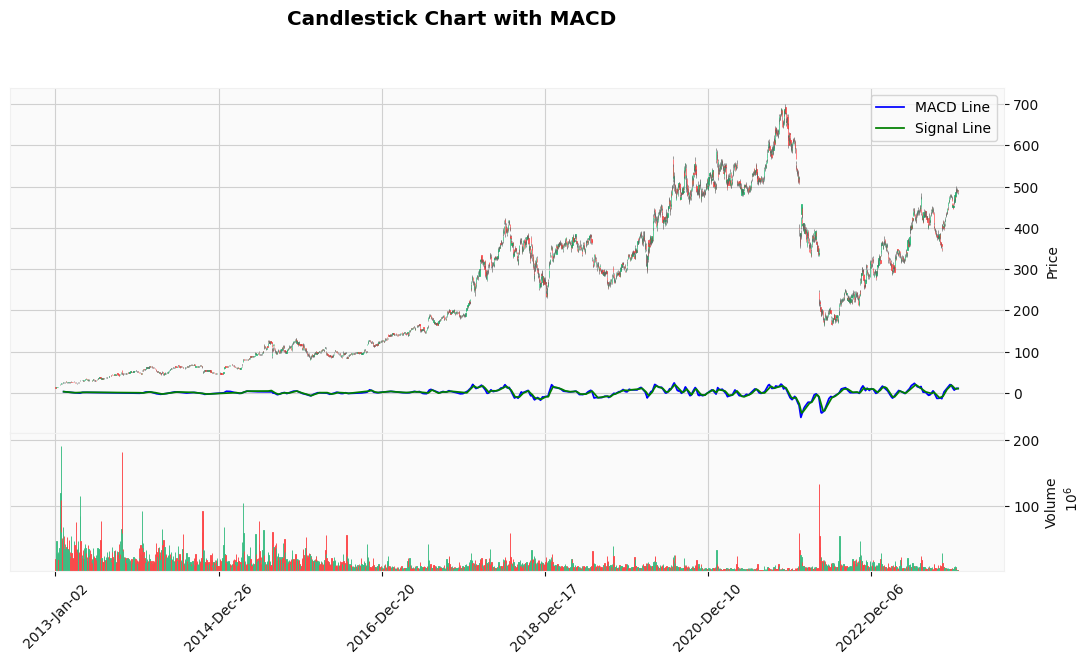

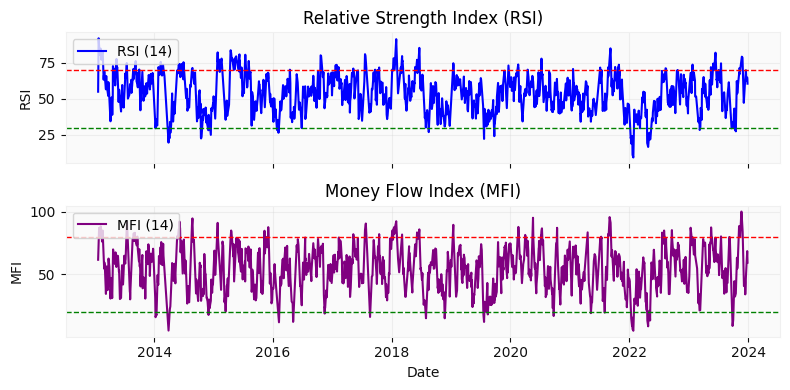

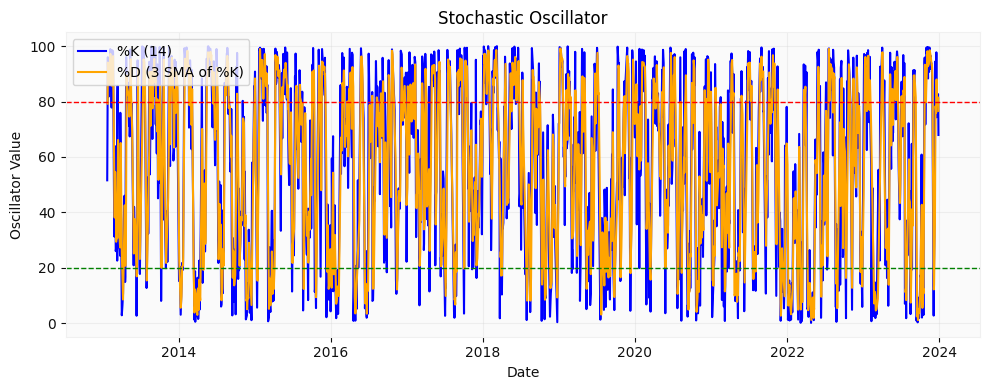

In [86]:
df_NFLX.index = df_NFLX['Date']

## 1. For the MACD and Signal Line on the candlestick chart
apds = [
    mpf.make_addplot(df_NFLX['MACD'], color='blue', label='MACD Line'),
    mpf.make_addplot(df_NFLX['Signal_Line'], color='green', label='Signal Line')
]

## 2. Plot candlestick chart with volume
mpf.plot(
    df_NFLX,
    type='candle',
    style='yahoo',
    volume=True,
    addplot=apds,
    title="Candlestick Chart with MACD",
    ylabel="Price",
    ylabel_lower="Volume",
    figratio=(8,4),
    figscale=1.2
)

## 3. Plot RSI and MFI
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8,4), sharex=True)

ax1.plot(df_NFLX['Date'], df_NFLX['RSI'], label='RSI (14)', color='blue')
ax1.axhline(70, color='red', linestyle='--', linewidth=1)   # overbought
ax1.axhline(30, color='green', linestyle='--', linewidth=1) # oversold
ax1.set_title("Relative Strength Index (RSI)")
ax1.set_ylabel("RSI")
ax1.legend(loc="upper left")
ax1.grid(True, alpha=0.3)

ax2.plot(df_NFLX['Date'], df_NFLX['MFI'], label='MFI (14)', color='purple')
ax2.axhline(80, color='red', linestyle='--', linewidth=1)   # overbought
ax2.axhline(20, color='green', linestyle='--', linewidth=1) # oversold
ax2.set_title("Money Flow Index (MFI)")
ax2.set_ylabel("MFI")
ax2.legend(loc="upper left")
ax2.grid(True, alpha=0.3)

# Shared x-axis (Date)
plt.xlabel("Date")
plt.tight_layout()
plt.show()

## 4. Plot Stochastic Oscillator
plt.figure(figsize=(10,4))

plt.plot(df_NFLX['Date'], df_NFLX['%K'], label='%K (14)', color='blue')
plt.plot(df_NFLX['Date'], df_NFLX['%D'], label='%D (3 SMA of %K)', color='orange')

# Overbought / Oversold lines
plt.axhline(80, color='red', linestyle='--', linewidth=1)
plt.axhline(20, color='green', linestyle='--', linewidth=1)

plt.title("Stochastic Oscillator")
plt.ylabel("Oscillator Value")
plt.xlabel("Date")
plt.legend(loc="upper left")
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()

### <a id='toc1_2_3_'></a>[Other related features](#toc0_)

#### <a id='toc1_2_3_1_'></a>[If the dividends/ split data is not available in the set, we can approximate Adjusted Closing Price to be close to Close Price](#toc0_)

In [ ]:
df_NFLX['Adjusted_Close_Price'] = df_NFLX['Close']

#### <a id='toc1_2_3_2_'></a>[Log Return calculated using Adjusted Close Price](#toc0_)

$$rt​=ln(Pt−1​Pt​​)$$

In [ ]:
df_NFLX["LogRet"] = np.log(df_NFLX["Adjusted_Close_Price"] / df_NFLX["Adjusted_Close_Price"].shift(1))

#### <a id='toc1_2_3_3_'></a>[Realized Volatility](#toc0_)

- Mainly requires Intradays (multiple row per 1 day meaning different prices based on hour bars with frequency 1-min, 5-min, 15-min)

then RV can be calculated by

$$
RV_t = \sqrt{\sum_{i=1}^{M} r_{t,i}^2}
​$$

where $r_{t,i}$ = intraday log return

However, since these are day-by-day market we don't have intradays so we can use these formulas instead

* Parkinson volatility (use High-Low)

$$σ^2 = \frac{1}{4 \ln(2)} \left( \ln \left( \frac{High}{Low} \right) \right)^2$$

* Rogers–Satchell Volatility

$$σ^2 = \ln \left( \frac{High}{Close} \right) \ln \left( \frac{High}{Open} \right) 
+ \ln \left( \frac{Low}{Close} \right) \ln \left( \frac{Low}{Open} \right)$$

In [ ]:
# Parkinson volatility
df_NFLX["ParkinsonVol"] = (1 / (4*np.log(2))) * (np.log(df_NFLX["High"] / df_NFLX["Low"]))**2

# Rogers-Satchell volatility
df_NFLX["RSVol"] = (np.log(df_NFLX["High"]/df_NFLX["Close"]) * np.log(df_NFLX["High"]/df_NFLX["Open"]) +
               np.log(df_NFLX["Low"]/df_NFLX["Close"]) * np.log(df_NFLX["Low"]/df_NFLX["Open"]))


#### <a id='toc1_2_3_4_'></a>[Some Time features like year, Month, weekday](#toc0_)

In [ ]:
df_NFLX['Year'] = df_NFLX['Date'].dt.year
df_NFLX['Month'] = df_NFLX['Date'].dt.month
df_NFLX['Weekday'] = df_NFLX['Date'].dt.weekday

In [97]:
df_NFLX.head()

,Date,Open,High,Low,Close,Volume,RSI,EMA_12,EMA_26,MACD,...,MFI,%K,%D,Adjusted_Close_Price,LogRet,ParkinsonVol,RSVol,Year,Month,Weekday
Date,,,,,,,,,,,,,,,,,,,,,
2013-01-02,2013-01-02,13.601429,13.687143,12.955714,13.144286,19431300,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,13.144286,NaN,0.001088,0.000957,2013,1,2
2013-01-03,2013-01-03,13.138571,13.988571,13.075714,13.798571,27912500,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,13.798571,0.048578,0.001643,0.001115,2013,1,3
2013-01-04,2013-01-04,13.791429,13.958571,13.648571,13.711429,17761100,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,13.711429,-0.006335,0.000182,0.000263,2013,1,4
2013-01-07,2013-01-07,13.770000,14.535714,13.731429,14.171429,45550400,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,14.171429,0.032998,0.001169,0.001462,2013,1,0
2013-01-08,2013-01-08,14.287143,14.427143,13.828571,13.880000,24714900,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,13.880000,-0.020779,0.000648,0.000498,2013,1,1


In [96]:
df_NFLX.columns

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'RSI', 'EMA_12',
       'EMA_26', 'MACD', 'Signal_Line', 'TP', 'MF', 'PMF', 'NMF', 'PMF_sum',
       'NMF_sum', 'MR', 'MFI', '%K', '%D', 'Adjusted_Close_Price', 'LogRet',
       'ParkinsonVol', 'RSVol', 'Year', 'Month', 'Weekday'],
      dtype='object')

## <a id='toc1_3_'></a>[Clean and Preprocessing](#toc0_)

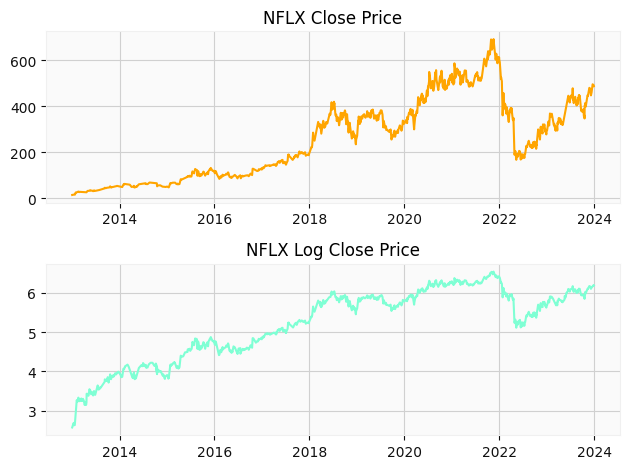

In [105]:
plt.subplot(2,1,1)
plt.plot(df_NFLX['Date'], df_NFLX['Close'], label='Close_Price', color='orange')
plt.title('NFLX Close Price')

plt.subplot(2,1,2)
plt.plot(df_NFLX['Date'], np.log(df_NFLX['Close']), label='Close_Price', color='aquamarine')
plt.title('NFLX Log Close Price')

plt.tight_layout()
plt.show()

In [ ]:
df_NFLX['Close_log'] = np.log(df_NFLX['Close'])

### <a id='toc1_3_1_'></a>[Check for stationarity of Close price](#toc0_)

In [113]:
### Test for differencing of non-seasonal patterns

def find_d(dataset, col): 
    i = 0
    temp = dataset
    while True:
        result = adfuller(temp[col].dropna())
        if result[1] < 0.05:
            print(f"Number of difference: {i}")
            print('ADF Statistic: %f' % result[0])
            print('p-value: %f' % result[1])
            break
        else:
            temp = temp.diff().dropna()
            i = i+1
            
            if temp[col].isna().all():  # Prevent infinite loop
                print("All values became NaN after differencing. Check data.")
                break
            
find_d(df_NFLX, 'Close')

Number of difference: 1
ADF Statistic: -11.096320
p-value: 0.000000


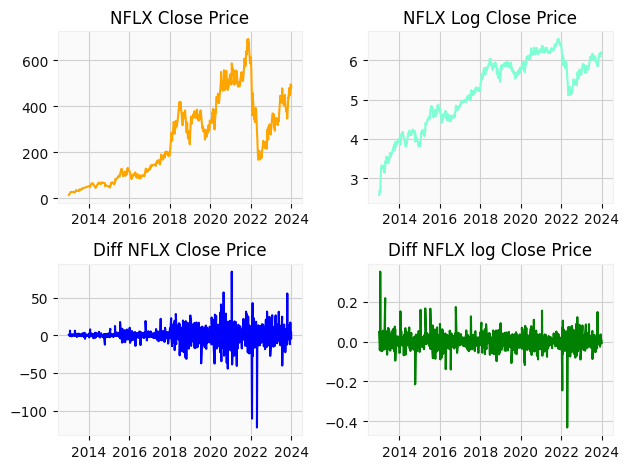

In [112]:
plt.subplot(2,2,1)
plt.plot(df_NFLX['Date'], df_NFLX['Close'], label='Close_Price', color='orange')
plt.title('NFLX Close Price')

plt.subplot(2,2,2)
plt.plot(df_NFLX['Date'], df_NFLX['Close_log'], label='Close_Price', color='aquamarine')
plt.title('NFLX Log Close Price')

plt.subplot(2,2,3)
plt.plot(df_NFLX['Date'], df_NFLX['Close'] - df_NFLX['Close'].shift(1), label='Close_Price', color='blue')
plt.title('Diff NFLX Close Price')

plt.subplot(2,2,4)
plt.plot(df_NFLX['Date'], df_NFLX['Close_log'] - df_NFLX['Close_log'].shift(1), label='Close_Price', color='green')
plt.title('Diff NFLX log Close Price')

plt.tight_layout()
plt.show()

For raw close price, the original series is not stationary, so we need to take the first differentiation to ensure the stationarity of the data. However, when we first take the log of the price the series itself is stationary and doesn't need another step of differencing to get the P< 0.05 in adf

We still need to apply several tests to see which processing method is more appropriate, here we apply a wider variety of test on the logging of raw series to see whether log is an appropriate approach

#### <a id='toc1_3_1_1_'></a>[Pre-requisites:](#toc0_)
Unit root (also called a unit root process or a difference stationary process): a stochastic trend in a time series, sometimes called "a random walk with drift", which is an unpredictable pattern occuring in a trend 

The reason why this is called "unit root" is due to the maths behind the process. A process can be written as a series of monomials (expression with a single term). Each monomials correspond to a root, if 1 of the root is 1 then that's a unit root. 

$$yt_​=ρy_{t−1}​+ε_t​, ε_t​∼iid(0,σ^2)$$

Unit root: p = 1 leads to 

$$y_t = y_{t-1} + ε_t$$

=> Non-stationary arises immediately when mean depends on initial values and variance grows with time

In more severe cases, unit root can also lead to 
- Spurious regression problem: When 2 uncorelated series both have unit roots, regressions between them often appear statistically significant (high $r^2$) even though there’s no real relationship. This can mislead into finding “false” correlations.
- Errant behavior (t-ratios will not follow a t-distribution)

#### <a id='toc1_3_1_2_'></a>[Augmented Dickey-Fuller Test (ADF test):](#toc0_)

Defines the stationary zone in a normal distribution and the series is stationary if the value is inside the rejection zone (5% significant level 2 tails)

#### <a id='toc1_3_1_3_'></a>[Kwiatkowski-Phillips-Schmidt-Shin Test (KPSS):](#toc0_)

Check if a series is stationary around a deterministic trend or mean, versus being non-stationary with a unit root
This is different from the ADF where
- H0: Data is stationary
- H1: Data is not stationary

The KPSS test is based on linear regression. It splits the data into 3 parts: a deterministic trend ($β_t$), a random walk ($r_t$), and a stationary error ($ε_t$), with the regression equation:

$$xt = r_t + β_t + ε_1$$

If the data is stationary, it will have a fixed element for an intercept or the series will be stationary around a fixed level. Data is normally log-transformed before running the KPSS test, to turn any exponential trends into linear ones.

Look at the P-value, if P-value < threshold then it's not stationary, if large, > threshold then it's stationary

#### <a id='toc1_3_1_4_'></a>[Ljung-Box Test](#toc0_)

#### <a id='toc1_3_1_5_'></a>[ARCH test](#toc0_)

In [116]:
s = df_NFLX['Close'].dropna()          # raw price
log_s = np.log(s)
log_ret = log_s.diff().dropna()

def adf_report(x, name="series"):
    stat, p, nlags, nobs, crit, icbest = adfuller(x, regression='c', autolag='AIC')
    print(f"{name}: ADF stat={stat:.3f}, p={p:.3f}, nlags={nlags}")

def kpss_report(x, name="series"):
    stat, p, lags, crit = kpss(x, regression='c', nlags='auto')
    print(f"{name}: KPSS stat={stat:.3f}, p={p:.3f}")

adf_report(log_s, "log-level")
adf_report(log_ret, "log-returns")
kpss_report(log_s, "log-level")
kpss_report(log_ret, "log-returns")

# diagnostics on returns
print("Ljung-Box (returns):", acorr_ljungbox(log_ret, lags=[10], return_df=True))
print("ARCH test (returns):", het_arch(log_ret))


log-level: ADF stat=-3.003, p=0.035, nlags=0
log-returns: ADF stat=-35.830, p=0.000, nlags=1
log-level: KPSS stat=7.413, p=0.010
log-returns: KPSS stat=0.364, p=0.093
Ljung-Box (returns):       lb_stat  lb_pvalue
10  19.426907   0.035164
ARCH test (returns): (8.044977525620418, 0.6244434695434866, 0.8036329479653961, 0.6252935161844597)


C:\Users\admin\AppData\Local\Temp\ipykernel_3436\976544709.py:10: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  stat, p, lags, crit = kpss(x, regression='c', nlags='auto')


From this, although taking the log price does reduce noise and exponential trend rise, the log still suffers from a relatively low KPSS value, indicating high non-stationarity, while the ADF is only slightly low.

In [ ]:
df_NFLX['Close_diff'] = df_NFLX['Close'] - df_NFLX['Close'].shift(1)

### Denoising

#### Seasonal-Trend Decomposition using LOESS (STL)

#### Hodrick-Prescott Filter (HP Filter)

#### Wavelets